In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import swifter

from glob import glob
from itertools import product
from matplotlib.ticker import AutoMinorLocator, MultipleLocator, ScalarFormatter
from tqdm.notebook import tqdm
from matplotlib.lines import Line2D

sns.set_style(style='whitegrid')

In [2]:
models = ['GRU', 'LSTM', 'N-BEATS', 'Transformer']
tasks = ['none', 'featurization', 'classification', 'forecasting']

markers = dict(zip(tasks, [',', 'X', 'o', '>']))

In [3]:
def plot(
    ylabel: str,
    ylogscale: bool = False,
    palette='colorblind',
    fig_name=None,
    fig_size=(12, 6),
    xticks_every=3,
    yticks_every=None,
    xticks_minor=None,
    markersize=6,
    markevery=(0.2, 0.1),
    linewidth=0.8,
    dashes=False,
    ylim=None,
    **kwargs
):
    fgrid = sns.lineplot(
        markevery=markevery,
        markersize=markersize,
        linewidth=linewidth,
        dashes=dashes,
        palette=palette,
        **kwargs
    )
    fgrid.figure.set_size_inches(fig_size)
    fgrid.xaxis.set_major_locator(MultipleLocator(xticks_every))
    if xticks_minor is None:
        xticks_minor = xticks_every
    fgrid.xaxis.set_minor_locator(AutoMinorLocator(xticks_minor))
    if yticks_every is not None:
        fgrid.yaxis.set_major_locator(MultipleLocator(yticks_every))
    
    fgrid.grid(which='major', color='#CCCCCC', linestyle='--')
    fgrid.grid(which='minor', color='#CCCCCC', linestyle=':')
    fgrid.set(ylabel=ylabel)
    if fig_name is not None:
        fgrid.get_figure().savefig(fig_name, format='pdf')
    if ylogscale:
        fgrid.set(yscale='log')
    if ylim is not None:
        fgrid.set(ylim=ylim)
    return fgrid

In [4]:
def plots_per_model(data: pd.DataFrame, 
                    x='epoch',
                    ylogscale: bool = False, 
                    legend_pos: int = 1, 
                    markers=markers, 
                    sharex=True,
                    sharey=True,
                    fig_size=(10, 7),
                    ncol=2,
                    **kwargs):
    fig, axes = plt.subplots(2, 2, sharex=sharex, sharey=sharey)
    for i, model in enumerate(models):
        curr_ax = axes[i // 2, i % 2]
        plot(
            data=data[data.model == model],
            x=x,
            markers=markers,
            legend=(i==legend_pos),
            ax=curr_ax,
            fig_size=fig_size,
            **kwargs
        )
        if ylogscale and not sharey:
            curr_ax.set_yscale('log')
        curr_ax.title.set_text(model)
    
    legend_ax = axes[legend_pos // 2, legend_pos % 2]
    if ncol != 1:
        handles, labels = legend_ax.get_legend_handles_labels()
        legend_ax.legend(handles=handles, labels=labels, ncol=ncol)
    fig.set_tight_layout(True)
    if ylogscale and sharey:
        axes[0, 0].set_yscale('log')
    return fig, axes

def accuracy_plots_per_model(data, y='value', ylabel='Classification accuracy', **kwargs):
    return plots_per_model(data=data[data.metric == 'acc'], y=y, ylabel=ylabel, **kwargs)

def cross_loss_plots_per_model(data, y='value', ylabel='Cross-entropy loss', ylogscale=True, **kwargs):
    return plots_per_model(data=data[data.metric == 'loss.cross'], y=y, ylabel=ylabel, ylogscale=ylogscale, **kwargs)

def mse_loss_plots_per_model(data, y='value', ylabel='MSE loss', ylogscale=True, **kwargs):
    return plots_per_model(data=data[data.metric == 'loss.mse'], y=y, ylabel=ylabel, ylogscale=ylogscale, **kwargs)

def triplet_loss_plots_per_model(data, y='value', ylabel='Triplet loss', ylogscale=True, **kwargs):
    return plots_per_model(data=data[data.metric == 'loss.triplet'], y=y, ylabel=ylabel, ylogscale=ylogscale, **kwargs)

In [5]:
def add_n_empty_items_to_legend(n, ax, ncol=2):
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles + [Line2D([], [], color="none")] * n, labels=labels + [''] * n, ncol=ncol)

In [6]:
def rolling(df, window: int, skip: int = 1):
    grouping_cols = [c for c in df.columns if c not in ['epoch', 'value']]
    l = []
    for tup, group in tqdm(df.groupby(grouping_cols)):
        sub_df = group[['epoch', 'value']].sort_values('epoch') \
                   .rolling(window=window, min_periods=1).mean().iloc[::skip].reset_index(drop=True)
        sub_df[grouping_cols] = tup
        l.append(sub_df)
    df_rolled = pd.concat(l).reset_index(drop=True)
    return df_rolled

## Random sampling

In [7]:
rs = pd.read_pickle('../../Resources/random-sampling.pkl')

In [8]:
rs.groupby(['run', 'set', 'metric']).count()['epoch'].describe()

count      240.000000
mean     23479.312500
std       7788.545172
min       5628.000000
25%      15477.000000
50%      21105.000000
75%      29547.000000
max      43617.000000
Name: epoch, dtype: float64

In [9]:
43617 / np.round(rs.epoch.max())

1407.0

In [10]:
rs_rolled = rolling(rs, window=700, skip=50)

  0%|          | 0/240 [00:00<?, ?it/s]

In [11]:
p_rs = {
    'style': 'set',
    'dashes': True,
    'markers': True,
    'hue': 'seed',
    'hue_order': list(map(lambda i: str(i), range(5))), # ['2', '3', '4']
    'xticks_every': 5,
    'xticks_minor': 5,
    'ncol': 2,
}

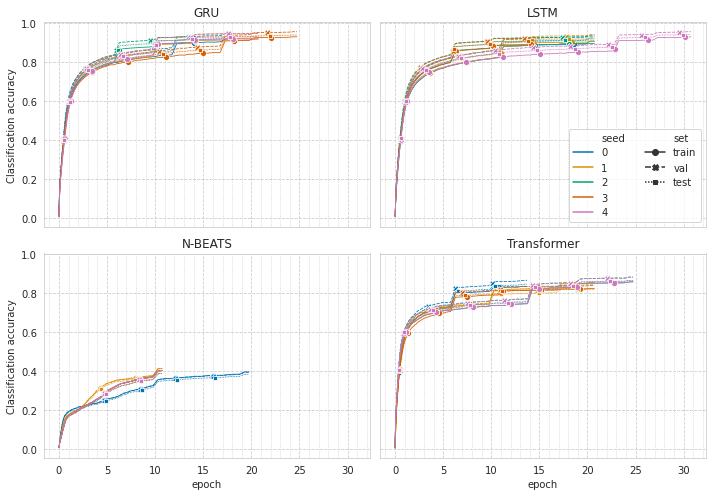

In [12]:
fig, axes = accuracy_plots_per_model(data=rs_rolled, 
                                     style_order=['train', 'val', 'test'],
                                     **p_rs,)

add_n_empty_items_to_legend(2, axes[0, 1])
fig.savefig('../../Resources/Thesis/random-sampling-classification-accuracy.pdf', format='pdf');

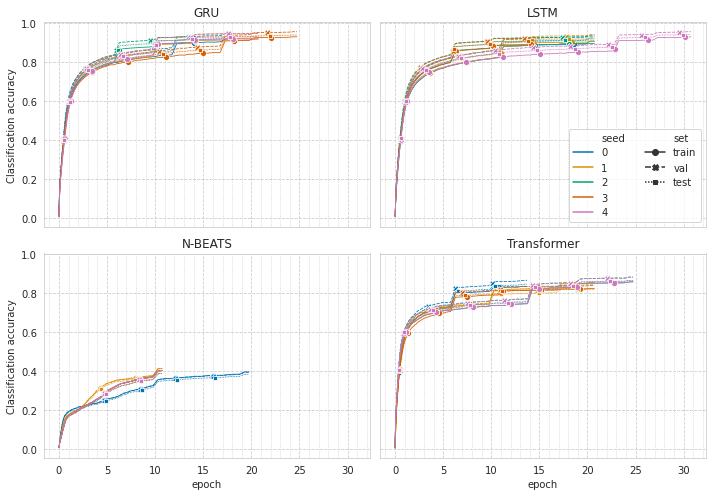

In [13]:
fig, axes = accuracy_plots_per_model(data=rs_rolled, 
                                     style_order=['train', 'val', 'test'],
                                     **p_rs,)

add_n_empty_items_to_legend(2, axes[0, 1])
fig.savefig('../../Resources/Thesis/random-sampling-classification-accuracy.pdf', format='pdf');

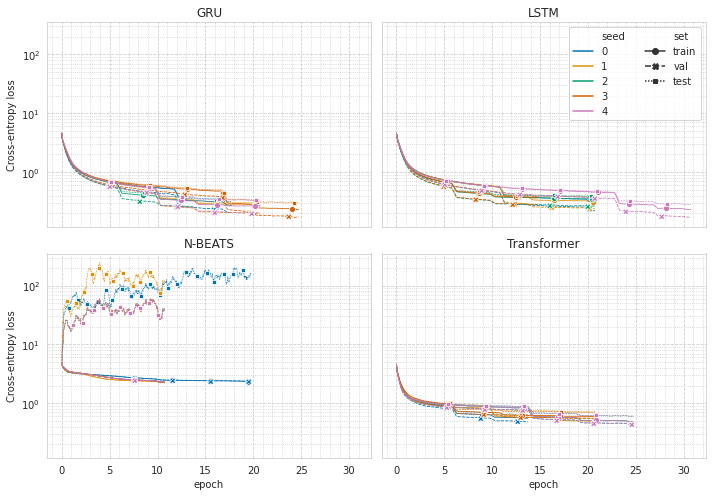

In [14]:
fig, axes = cross_loss_plots_per_model(data=rs_rolled,
                                       style_order=['train', 'val', 'test'],
                                       **p_rs)
add_n_empty_items_to_legend(2, axes[0, 1])
fig.savefig('../../Resources/Thesis/random-sampling-classification-loss.pdf', format='pdf');

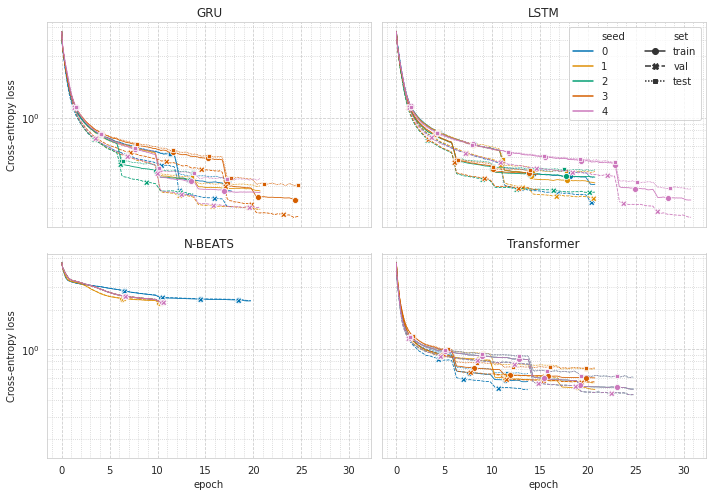

In [15]:
fig, axes = cross_loss_plots_per_model(data=rs_rolled[~((rs_rolled.model == 'N-BEATS') & (rs_rolled.set == 'test'))],
                                       style_order=['train', 'val', 'test'],
                                       **p_rs)
add_n_empty_items_to_legend(2, axes[0, 1])
fig.savefig('../../Resources/Thesis/random-sampling-classification-loss-no-nbeats-test.pdf', format='pdf');

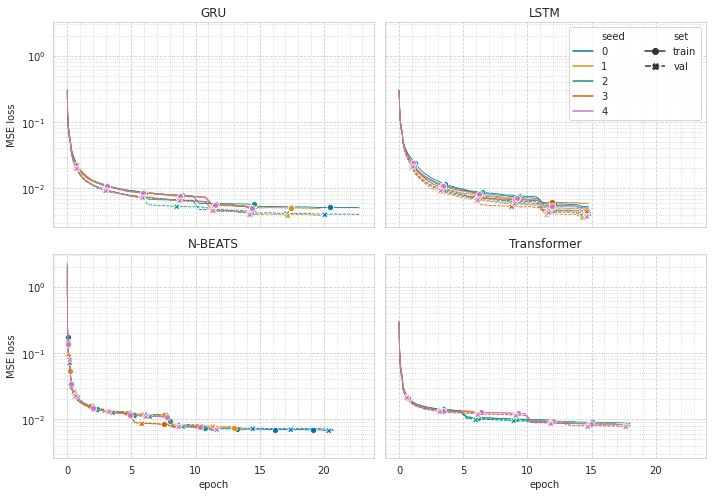

In [16]:
fig, axes = mse_loss_plots_per_model(data=rs_rolled, 
                                     style_order=['train', 'val'],
                                     **p_rs,)
add_n_empty_items_to_legend(2, axes[0, 1])
fig.savefig('../../Resources/Thesis/random-sampling-forecasting-loss-no-test.pdf', format='pdf');

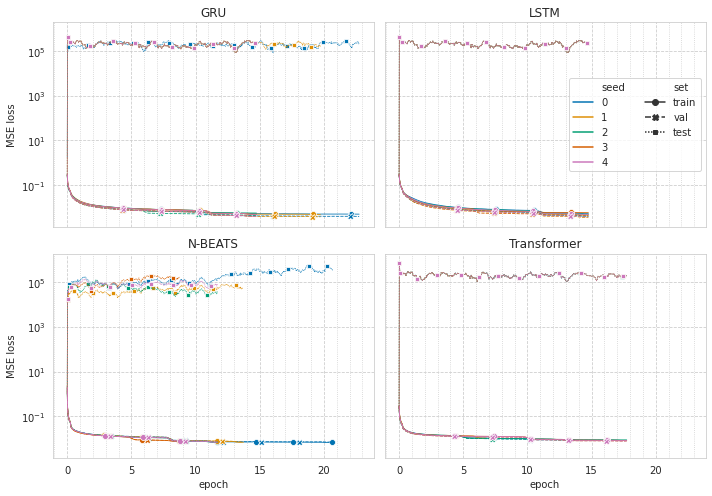

In [17]:
fig, axes = mse_loss_plots_per_model(data=rs_rolled, 
                                     style_order=['train', 'val', 'test'],
                                     **p_rs,)
add_n_empty_items_to_legend(2, axes[0, 1])
fig.savefig('../../Resources/Thesis/random-sampling-forecasting-loss.pdf', format='pdf');

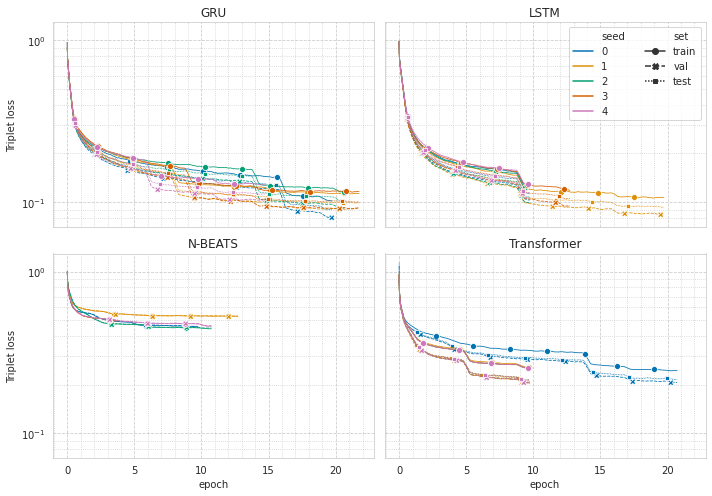

In [18]:
fig, axes = triplet_loss_plots_per_model(data=rs_rolled[~((rs_rolled.model == 'N-BEATS') & (rs_rolled.set == 'test'))],
                                         style_order=['train', 'val', 'test'],
                                         **p_rs,)
add_n_empty_items_to_legend(2, axes[0, 1])
fig.savefig('../../Resources/Thesis/random-sampling-featurization-loss-no-nbeats-test.pdf', format='pdf');

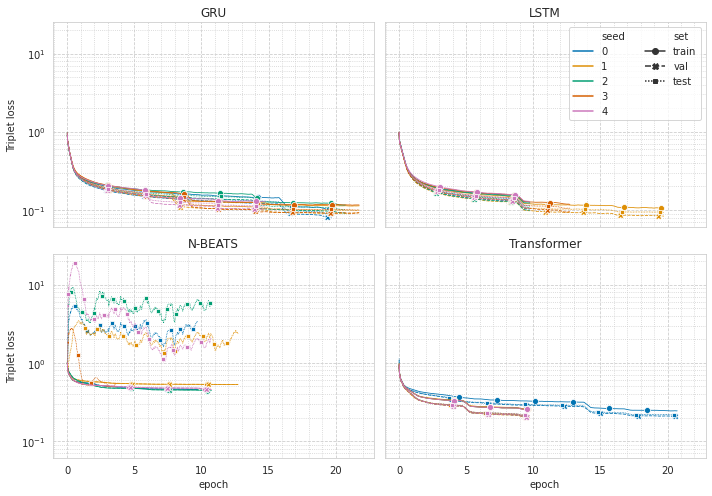

In [19]:
fig, axes = triplet_loss_plots_per_model(data=rs_rolled,
                                         style_order=['train', 'val', 'test'],
                                         **p_rs,)
add_n_empty_items_to_legend(2, axes[0, 1])
fig.savefig('../../Resources/Thesis/random-sampling-featurization-loss.pdf', format='pdf');

## Feature Freeze

In [20]:
def pre_task_loss_plots_per_model(df: pd.DataFrame, task: str, **kwargs):
    plot_f = {
        'classification': cross_loss_plots_per_model,
        'forecasting': mse_loss_plots_per_model,
        'featurization': triplet_loss_plots_per_model,
    }
    return plot_f[task](
        data=df[df.task == task],
        hue_order=list(filter(lambda s: s != task, tasks)),
        **kwargs
    )

In [21]:
ff = pd.read_pickle('../../Resources/feature-freeze.pkl')

In [22]:
ff.groupby(['run', 'set', 'metric']).count()['epoch'].describe()

count      120.000000
mean     23953.125000
std      10213.439903
min       7500.000000
25%      15000.000000
50%      26250.000000
75%      31875.000000
max      41250.000000
Name: epoch, dtype: float64

In [23]:
41250 / np.round(ff.epoch.max())

1875.0

In [24]:
ff_rolled = rolling(ff, window=500, skip=20)

  0%|          | 0/120 [00:00<?, ?it/s]

In [25]:
p_ff = {
    'hue': 'pre-training task',
    'style': 'set',
    'dashes': True,
    'markers': True,
    'xticks_every': 2,
    'xticks_minor': 2,
    'ncol': 2,
}

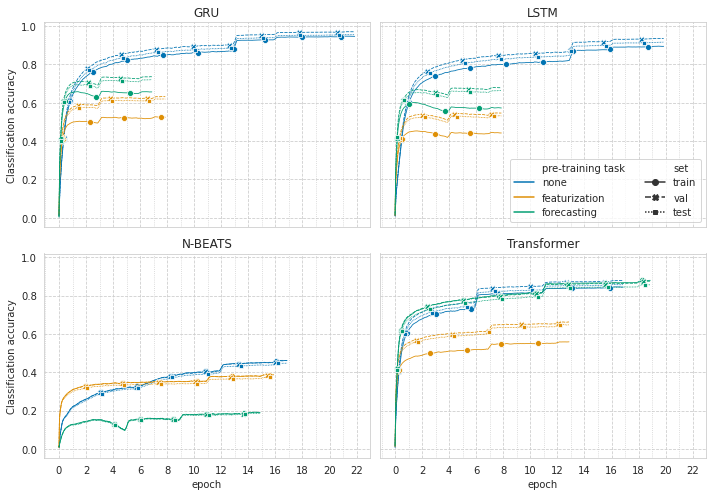

In [26]:
fig, axes = accuracy_plots_per_model(
    data=ff_rolled,
    style_order=['train', 'val', 'test'],
    hue_order=list(filter(lambda s: s != 'classification', tasks)),
    **p_ff
)
fig.savefig('../../Resources/Thesis/feature-freeze-classification-accuracy.pdf', format='pdf');

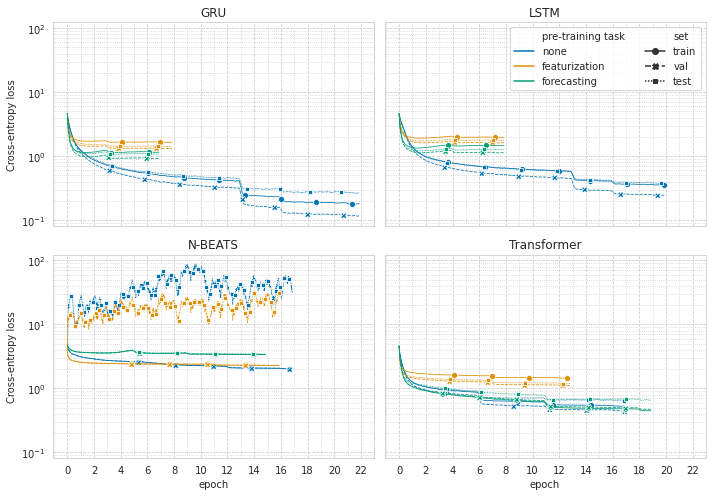

In [27]:
fig, axes = pre_task_loss_plots_per_model(ff_rolled, 
                                          task='classification', 
                                          style_order=['train', 'val', 'test'],
                                          **p_ff)
fig.savefig('../../Resources/Thesis/feature-freeze-classification-loss.pdf', format='pdf');

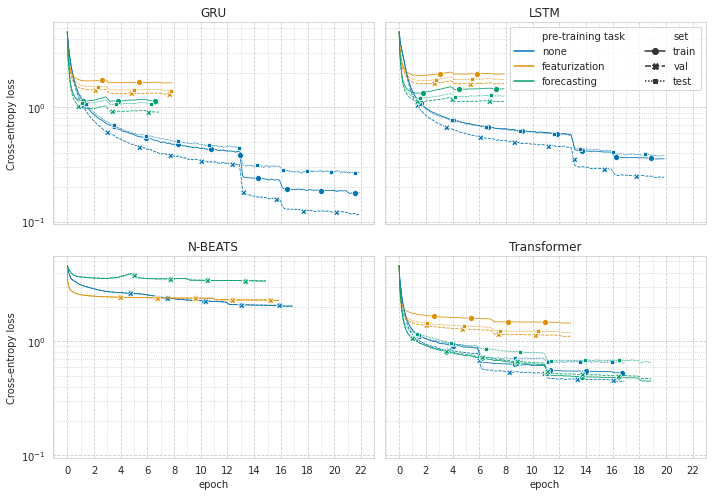

In [28]:
fig, axes = pre_task_loss_plots_per_model(ff_rolled[~((ff_rolled.model == 'N-BEATS') & (ff_rolled.set == 'test'))], 
                                          task='classification', 
                                          style_order=['train', 'val', 'test'],
                                          **p_ff)
fig.savefig('../../Resources/Thesis/feature-freeze-classification-loss-no-nbeats-test.pdf', format='pdf');

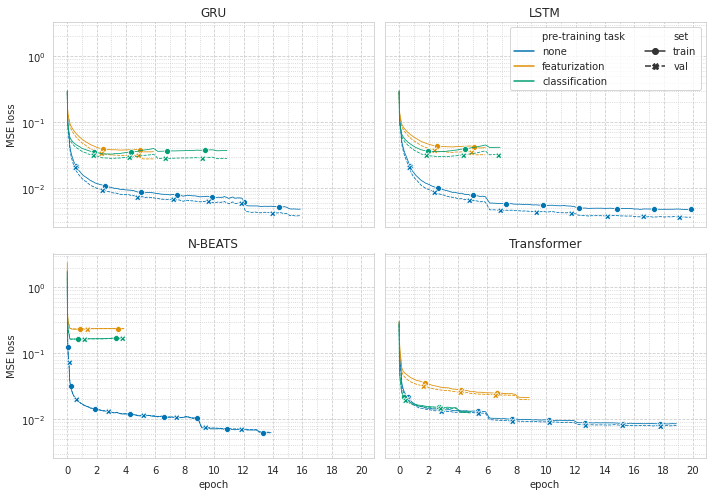

In [29]:
fig, axes = pre_task_loss_plots_per_model(ff_rolled,
                                          task='forecasting',
                                          style_order=['train', 'val'],
                                          **p_ff)
fig.savefig('../../Resources/Thesis/feature-freeze-forecasting-loss-no-test.pdf', format='pdf');

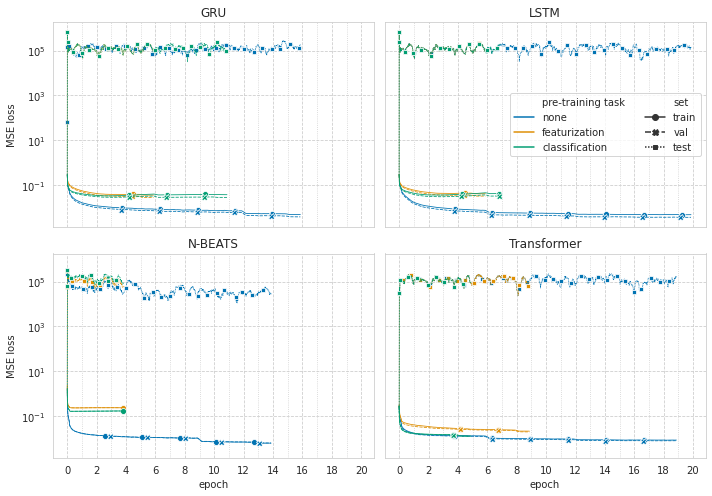

In [30]:
fig, axes = pre_task_loss_plots_per_model(ff_rolled,
                                          task='forecasting',
                                          style_order=['train', 'val', 'test'],
                                          **p_ff)
fig.savefig('../../Resources/Thesis/feature-freeze-forecasting-loss.pdf', format='pdf');

## Prober

In [31]:
pr = pd.read_pickle('../../Resources/prober.pkl')

In [32]:
pr.groupby(['run', 'set', 'metric']).count()['epoch'].describe()

count      192.000000
mean     33017.578125
std       9189.296015
min      13125.000000
25%      28125.000000
50%      37500.000000
75%      37500.000000
max      50625.000000
Name: epoch, dtype: float64

In [33]:
50625 / np.round(pr.epoch.max())

1875.0

In [34]:
pr_rolled = rolling(pr, window=500, skip=20)

  0%|          | 0/192 [00:00<?, ?it/s]

In [35]:
pr_rolled['task(s)'] = (pr_rolled['pre-training task'] + ' -> ' + pr_rolled['task'])\
    .str.replace('none -> ', '')\
    .str.replace('classification', 'clas.')\
    .str.replace('forecasting', 'fore.')\
    .str.replace('featurization', 'feat.')

In [36]:
prober_tasks = sorted(pr_rolled['task(s)'].unique(), key=lambda s: (len(s.split('->')), s))

In [37]:
p_pr = {
    'style': 'set',
    'style_order': ['train', 'val', 'test'],
    'hue': 'task(s)',
    'markers': True,
    'dashes': True,
    'xticks_every': 2,
    'ncol': 2,
}

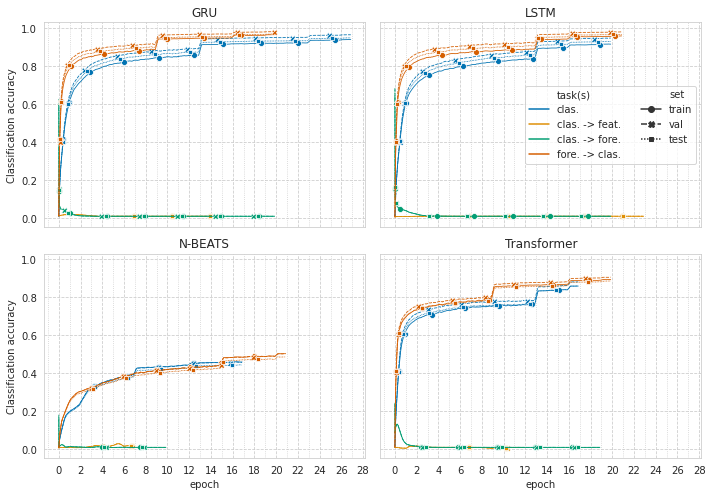

In [38]:
fig, axes = accuracy_plots_per_model(data=pr_rolled, **p_pr)
add_n_empty_items_to_legend(1, axes[0, 1])
fig.savefig('../../Resources/Thesis/prober-classification-accuracy.pdf', format='pdf');

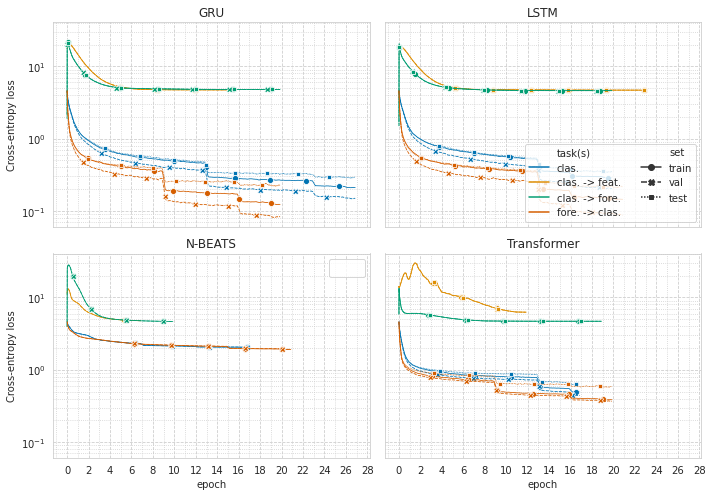

In [39]:
fig, axes = cross_loss_plots_per_model(
    data=pr_rolled[~((pr_rolled.model == 'N-BEATS') & (pr_rolled.set == 'test'))], **p_pr
)
add_n_empty_items_to_legend(1, axes[1, 0])
fig.savefig('../../Resources/Thesis/prober-classification-loss-no-nbeats-test.pdf', format='pdf');

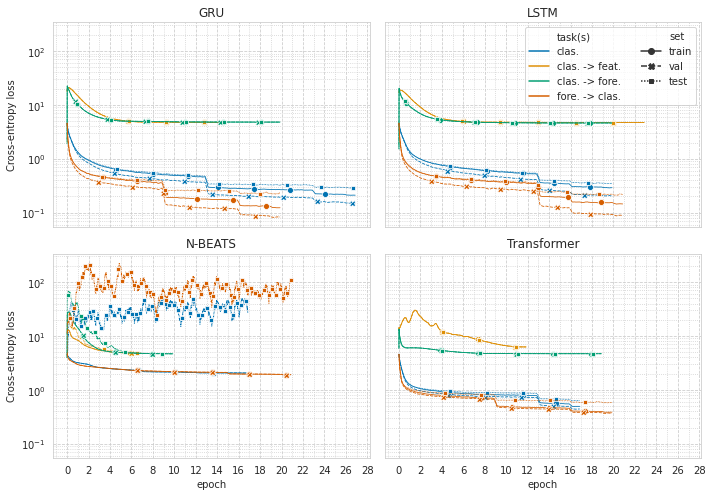

In [40]:
fig, axes = cross_loss_plots_per_model(
    data=pr_rolled, **p_pr
)
add_n_empty_items_to_legend(1, axes[0, 1])
fig.savefig('../../Resources/Thesis/prober-classification-loss.pdf', format='pdf');

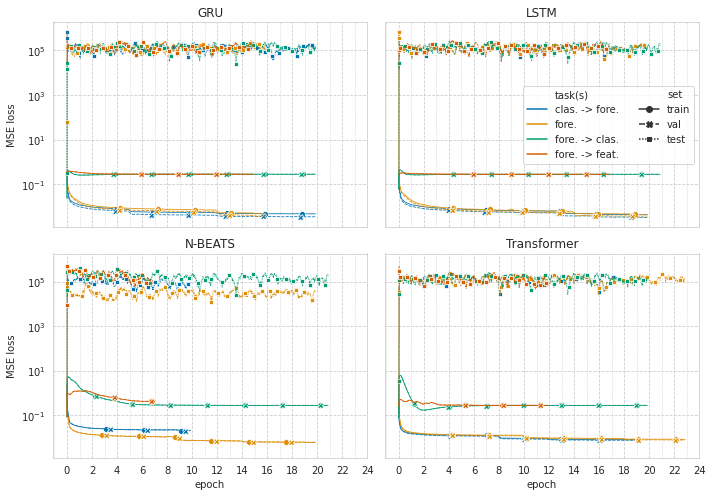

In [41]:
fig, axes = mse_loss_plots_per_model( 
    data=pr_rolled, **p_pr
)
add_n_empty_items_to_legend(1, axes[0, 1])
fig.savefig('../../Resources/Thesis/prober-forecasting-loss.pdf', format='pdf');

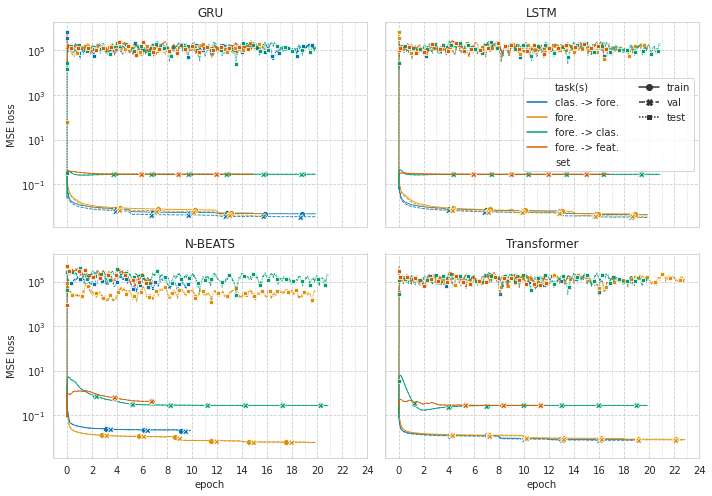

In [42]:
fig, axes = mse_loss_plots_per_model( 
    data=pr_rolled, **p_pr
)
add_n_empty_items_to_legend(2, axes[0, 1])
fig.savefig('../../Resources/Thesis/prober-forecasting-loss-no-test.pdf', format='pdf');

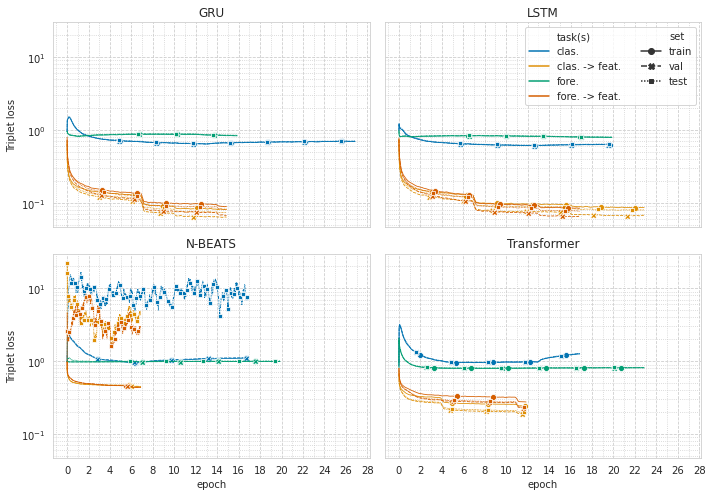

In [43]:
fig, axes = triplet_loss_plots_per_model( 
    data=pr_rolled, **p_pr
)
add_n_empty_items_to_legend(1, axes[0, 1])
fig.savefig('../../Resources/Thesis/prober-featurization-loss.pdf', format='pdf');

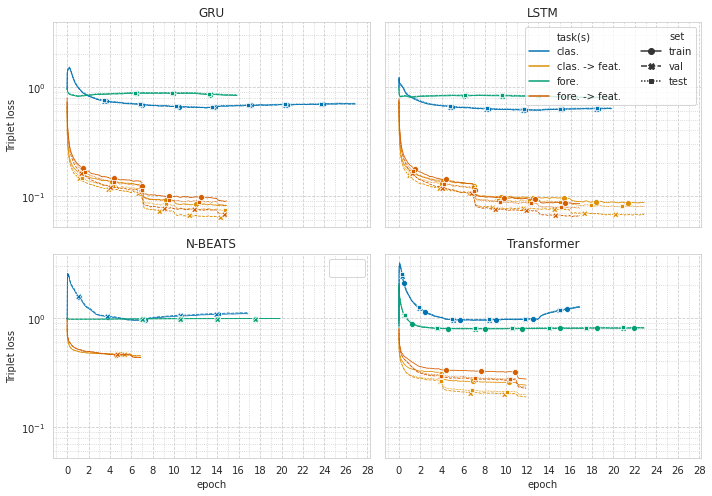

In [44]:
fig, axes = triplet_loss_plots_per_model( 
    data=pr_rolled[~((pr_rolled.model == 'N-BEATS') & (pr_rolled.set == 'test'))], **p_pr
)
add_n_empty_items_to_legend(1, axes[1, 0])
fig.savefig('../../Resources/Thesis/prober-featurization-loss-no-nbeats-test.pdf', format='pdf');

## Few Shot (Sprott)

In [45]:
fs = pd.read_pickle('../../Resources/few-shot.pkl')

In [46]:
fs.groupby(['run', 'set', 'metric']).count()['value'].describe()

count     480.000000
mean     1361.356250
std       487.764951
min       564.000000
25%      1034.000000
50%      1316.000000
75%      1786.000000
max      2726.000000
Name: value, dtype: float64

In [47]:
2726 / np.round(fs.epoch.max())

94.0

In [48]:
fs_rolled = rolling(fs, window=100, skip=5)

  0%|          | 0/480 [00:00<?, ?it/s]

In [50]:
p_fs = {
    'x': 'epoch',
    'hue': 'attractors, pre-training',
    'style': 'set',
    'xticks_every': 2,
    'dashes': True,
    'markers': True,
    #'ncol': 3,
}

In [51]:
fs_filtered = fs_rolled[fs_rolled['pre-training'] != 'none'].copy()

In [52]:
fs_filtered['attractors, pre-training'] = fs_filtered['attractors'] + ', ' + fs_filtered['pre-training']

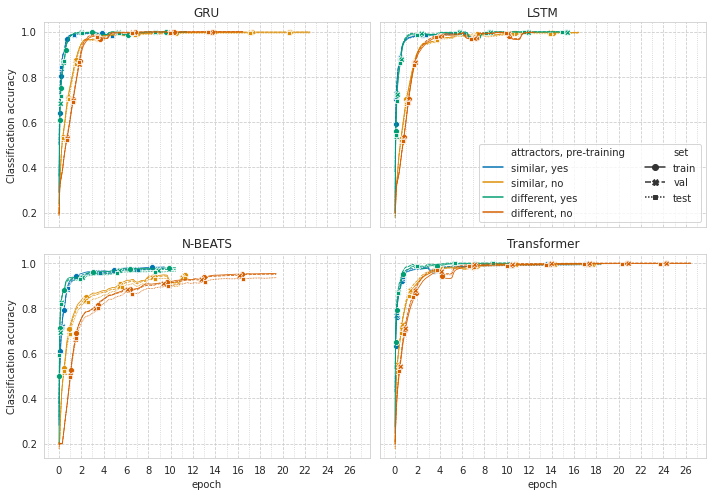

In [53]:
fig, axes = accuracy_plots_per_model(data=fs_filtered,
                                     style_order=['train', 'val', 'test'],
                                     **p_fs)
add_n_empty_items_to_legend(1, axes[0, 1])
fig.savefig('../../Resources/Thesis/few-shot-classification-accuracy.pdf', format='pdf');

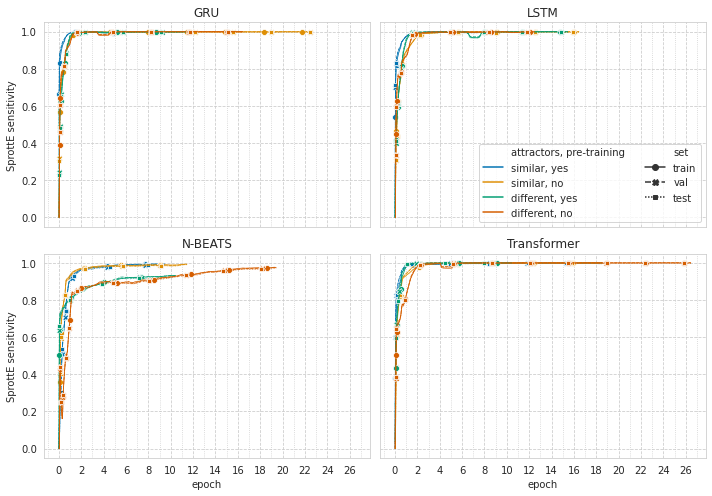

In [54]:
fig, axes = plots_per_model(
    data=fs_filtered[fs_filtered.metric == 'SprottE.sensitivity'],
    style_order=['train', 'val', 'test'],
    y='value', ylabel='SprottE sensitivity', ylogscale=False,
    **p_fs
)
add_n_empty_items_to_legend(1, axes[0, 1])
fig.savefig('../../Resources/Thesis/few-shot-sprott-sensitivity.pdf', format='pdf');

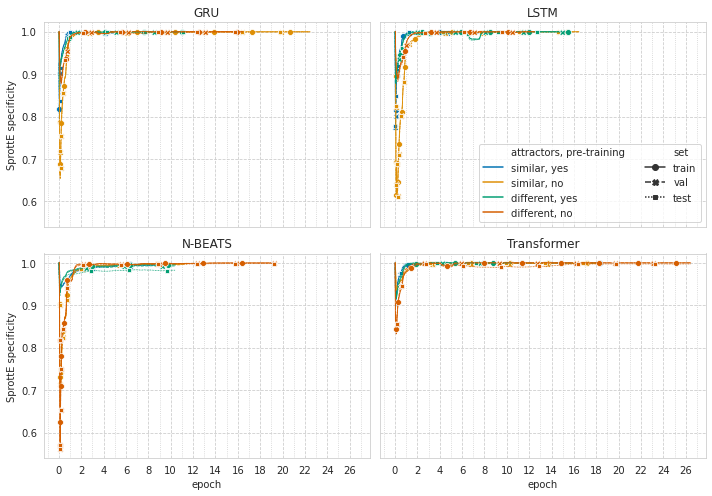

In [55]:
fig, axes = plots_per_model(
    data=fs_filtered[fs_filtered.metric == 'SprottE.specificity'],
    style_order=['train', 'val', 'test'],
    y='value', ylabel='SprottE specificity', ylogscale=False, 
    **p_fs
)
add_n_empty_items_to_legend(1, axes[0, 1])
fig.savefig('../../Resources/Thesis/few-shot-sprott-specificity.pdf', format='pdf');

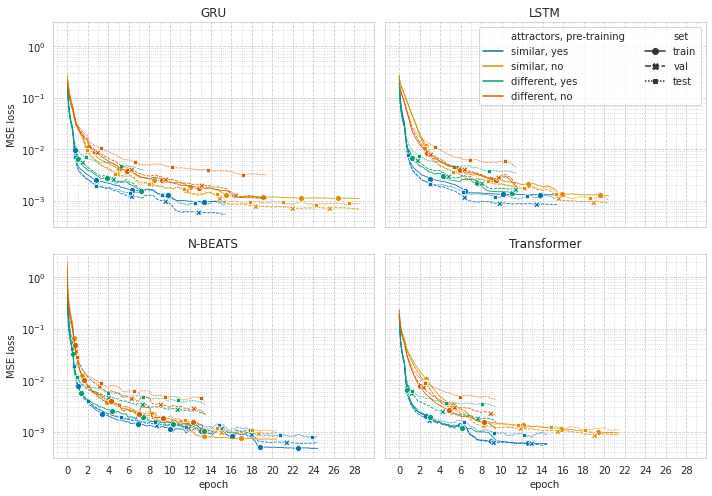

In [56]:
fig, axes = mse_loss_plots_per_model(data=fs_filtered, 
                                     style_order=['train', 'val', 'test'],
                                     **p_fs)
add_n_empty_items_to_legend(1, axes[0, 1])
fig.savefig('../../Resources/Thesis/few-shot-forecasting-loss.pdf', format='pdf');

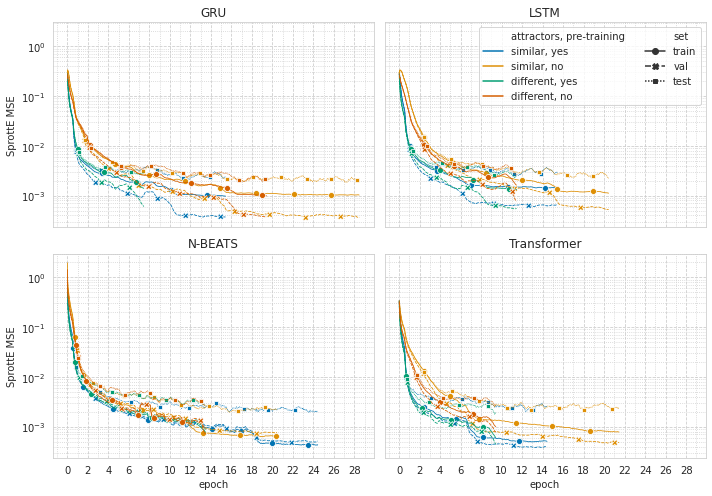

In [57]:
fig, axes = plots_per_model(
    data=fs_filtered[fs_filtered.metric == 'SprottE.loss.mse'],
    style_order=['train', 'val', 'test'],
    y='value', ylabel='SprottE MSE', ylogscale=True,
    **p_fs
)
add_n_empty_items_to_legend(1, axes[0, 1])
fig.savefig('../../Resources/Thesis/few-shot-sprott-mse.pdf', format='pdf');

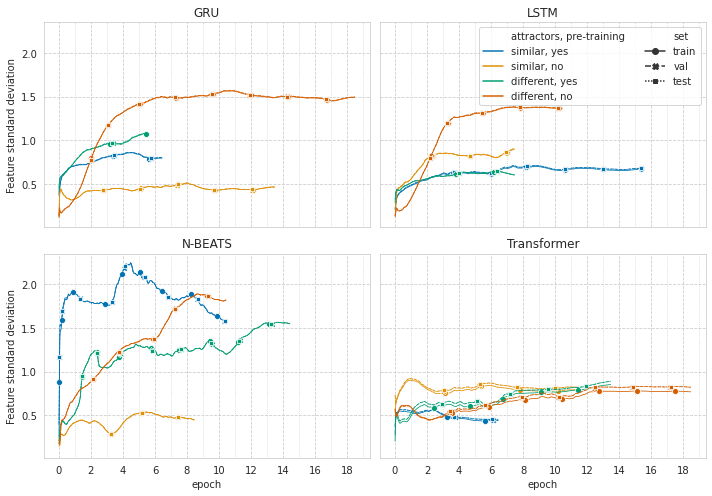

In [58]:
fig, axes = plots_per_model(
    data=fs_filtered[fs_filtered.metric == 'SprottE.feature.std'], 
    style_order=['train', 'val', 'test'],
    y='value', ylabel='Feature standard deviation', ylogscale=False, 
    **p_fs
)
add_n_empty_items_to_legend(1, axes[0, 1])
fig.savefig('../../Resources/Thesis/few-shot-sprott-feature-std.pdf', format='pdf');

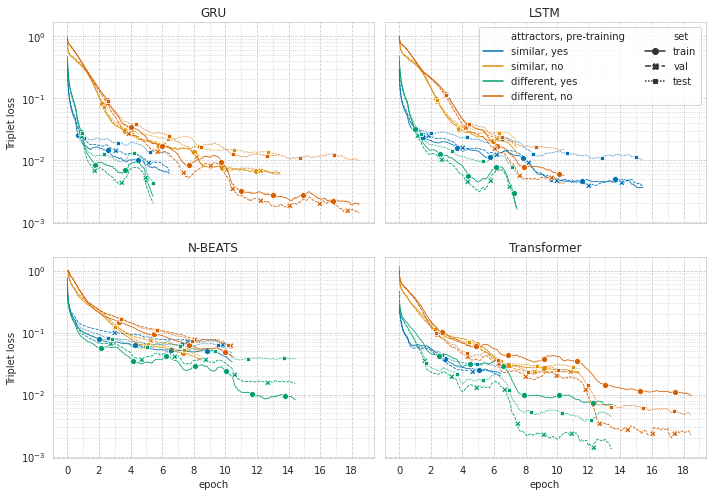

In [59]:
fig, axes = plots_per_model(
    data=fs_filtered[fs_filtered.metric == 'loss.triplet'], 
    style_order=['train', 'val', 'test'],
    y='value', ylabel='Triplet loss', ylogscale=True, 
    **p_fs
)
add_n_empty_items_to_legend(1, axes[0, 1])
fig.savefig('../../Resources/Thesis/few-shot-featurisation-loss.pdf', format='pdf');